In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import os
import pandas as pd
import random

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

# Data Processing
## Import Data

In [5]:
!wget https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /home/jupyter/+data/sarcasm.json

--2021-06-12 19:29:53--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.128, 74.125.195.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/home/jupyter/+data/sarcasm.json’

/home/jupyter/+data 100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2021-06-12 19:29:53 (106 MB/s) - ‘/home/jupyter/+data/sarcasm.json’ saved [5643545/5643545]



In [2]:
import json
with open("/home/jupyter/+data/sarcasm.json", "r") as f:
    datastore = json.load(f)

In [3]:
sentences = []
labels = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

from sklearn.model_selection import train_test_split
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, labels, train_size=0.9, shuffle=True, random_state=138)

## Tokenize

In [6]:
vocab_size = 5000
embedding_dim = 16
max_length = 20
trunc_type = "post"
oov_tok = "<OOV>"
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)

word_index = tokenizer.word_index
print(len(word_index))
# print(word_index)

Using TensorFlow backend.


28132


In [31]:
train_sequences = tokenizer.texts_to_sequences(train_sentences)
train_padded = pad_sequences(train_sequences, padding='post', maxlen=max_length, truncating=trunc_type)
train_labels = np.array(train_labels)
print(train_padded.shape)

test_sequences = tokenizer.texts_to_sequences(test_sentences)
test_padded = pad_sequences(test_sequences, padding='post', maxlen=max_length, truncating=trunc_type)
test_labels = np.array(test_labels) 

(24038, 20)


In [49]:
train_data = tf.data.Dataset.from_tensor_slices((train_padded, train_labels))
test_data = tf.data.Dataset.from_tensor_slices((test_padded, test_labels))

# Model

In [52]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_learning_curves(history):
    acc = history.history["acc"]
    val_acc = history.history["val_acc"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(acc))
    plt.figure(figsize=(16, 5))
    acc_plt = plt.subplot(1, 2, 1)
    acc_plt.plot(epochs, acc, "bo", label="Training accuracy")
    acc_plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.legend()
#     plt.gca().set_ylim(0, 1)
    
    loss_plt = plt.subplot(1, 2, 2)
    loss_plt.plot(epochs, loss, "bo", label="Training loss")
    loss_plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.legend()
#     plt.gca().set_ylim(0, 1)
    plt.show()

In [53]:
model = keras.Sequential([
    keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
#     keras.layers.Flatten(),
    keras.layers.GlobalAvgPool1D(),
    keras.layers.Dense(16, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid")
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 16)            80000     
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 80,289
Trainable params: 80,289
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["acc"])

In [69]:
history = model.fit(train_padded,
                    np.array(train_labels),
                    epochs=10,
                    validation_data=(test_padded, np.array(test_labels)))

Epoch 1/10
752/752 [==============================] - 2s 3ms/step - loss: 0.1037 - acc: 0.9651 - val_loss: 0.5653 - val_acc: 0.8341
Epoch 2/10
151/752 [=====>........................] - ETA: 1s - loss: 0.0892 - acc: 0.9698

KeyboardInterrupt: 

In [72]:
train_batch = train_data.batch(32).prefetch(1)
test_batch = test_data.batch(32).prefetch(1)

In [73]:
history = model.fit(train_batch,
                    epochs=10,
                    validation_data=test_batch)

Epoch 1/10
752/752 [==============================] - 2s 3ms/step - loss: 0.1005 - acc: 0.9659 - val_loss: 0.5946 - val_acc: 0.8315
Epoch 2/10
752/752 [==============================] - 2s 3ms/step - loss: 0.0967 - acc: 0.9683 - val_loss: 0.6184 - val_acc: 0.8278
Epoch 3/10
752/752 [==============================] - 2s 3ms/step - loss: 0.0937 - acc: 0.9695 - val_loss: 0.6449 - val_acc: 0.8282
Epoch 4/10
752/752 [==============================] - 2s 3ms/step - loss: 0.0905 - acc: 0.9706 - val_loss: 0.6697 - val_acc: 0.8274
Epoch 5/10
752/752 [==============================] - 2s 3ms/step - loss: 0.0872 - acc: 0.9720 - val_loss: 0.6930 - val_acc: 0.8267
Epoch 6/10
752/752 [==============================] - 2s 3ms/step - loss: 0.0838 - acc: 0.9730 - val_loss: 0.7181 - val_acc: 0.8255
Epoch 7/10
752/752 [==============================] - 2s 3ms/step - loss: 0.0808 - acc: 0.9740 - val_loss: 0.7476 - val_acc: 0.8255
Epoch 8/10
752/752 [==============================] - 2s 3ms/step - loss: 0.

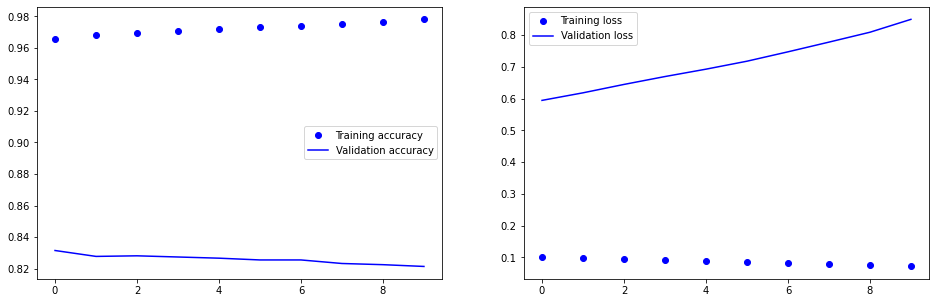

In [74]:
plot_learning_curves(history)